In [1]:
%config InlineBackend.figure_format = 'retina' #comment out if not using Mac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import os

### Checking single experiment

In [35]:
def plot_tandem_solar_cells(EQE_top_fp, EQE_bot_fp, R_fp, Spectrum_fp):
    # Load data from file paths
    EQE_top_df = pd.read_csv(EQE_top_fp)
    EQE_bot_df = pd.read_csv(EQE_bot_fp)
    R_df = pd.read_csv(R_fp)
    AM15 = pd.read_csv(Spectrum_fp)

    # Physical constants
    h = 6.62607015e-34  # Planck's constant, in m² kg / s
    c = 3.00e8  # speed of light, in m/s
    q = 1.602176634e-19  # charge of an electron, in C

    # Convert wavelength from nm to m
    AM15['wl_m'] = AM15['wl'] * 1e-9

    # Calculate energy of photons in the AM1.5 spectrum
    AM15['E'] = h * c / AM15['wl_m']

    # Calculate photon flux in the AM1.5 spectrum
    AM15['phi'] = AM15['power'] / AM15['E']

    R = (R_df['R']) / 100

    # Interpolate EQE data to match the wavelength values of the AM15 dataframe
    f1 = interp1d(EQE_top_df['wls'], EQE_top_df['eqe'], kind='linear', bounds_error=False, fill_value=(0,0))
    EQE_top_df_interpolated = f1(AM15['wl'])
    # Cut off the range within the min and max of EQE_top_df['wls']
    # EQE_top_df_interpolated = np.where((AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max()), EQE_top_df_interpolated, 0)

    # Interpolate EQE data to match the wavelength values of the AM15 dataframe
    f2 = interp1d(EQE_bot_df['wls'], EQE_bot_df['eqe'], kind='linear', bounds_error=False, fill_value=(0,0))
    EQE_bot_df_interpolated = f2(AM15['wl'])
    # Cut off the range within the min and max of EQE_bot_df['wls']
    # EQE_bot_df_interpolated = np.where((AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max()), EQE_bot_df_interpolated, 0)


    # Interpolate R data to match the wavelength values of the AM15 dataframe
    f3 = interp1d(R_df['nm'], R, kind='linear', bounds_error=False, fill_value=(0,0))
    R_df_interpolated = f3(AM15['wl'])



    combined_EQE = EQE_top_df_interpolated + EQE_bot_df_interpolated
    PA_loss = 1 - combined_EQE - R_df_interpolated

    # Calculate the total jsc current for each respective cell by integrating the EQE over the AM1.5 spectrum
    jsc_top = np.trapz(EQE_top_df_interpolated * AM15['phi'], AM15['wl']) * q / 10  # convert from A/m² to mA/cm²
    jsc_bot = np.trapz(EQE_bot_df_interpolated * AM15['phi'], AM15['wl']) * q / 10  # convert from A/m² to mA/cm²
    jsc_R = np.trapz(R_df_interpolated * AM15['phi'], AM15['wl']) * q / 10  # convert from A/m² to mA/cm²
    jsc_PA = np.trapz(PA_loss * AM15['phi'], AM15['wl']) * q / 10  # convert from A/m² to mA/cm²

    plt.figure(figsize=(10, 5))

    # Plot EQE and reflection losses
    plt.subplot(1, 2, 2)
    plt.xlim([300, 1200])
    plt.ylim(0, 1)



    # Parasitic losses
    plt.plot(AM15['wl'], combined_EQE, label=f'Parasitic Losses: {jsc_PA:.2f} mA/cm$^2$', color='gray')
    plt.fill_between(AM15['wl'], combined_EQE, 1 - R_df_interpolated, color='lightgray', alpha=1)

    # Top EQE Plot in the range of the orignal measurement
    plt.plot(AM15['wl'][(AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max())], 
            EQE_top_df_interpolated[(AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max())], 
            label=f'Top Cell Jsc: {jsc_top:.2f} mA/cm$^2$', color='dodgerblue', linewidth=2)
    plt.fill_between(AM15['wl'], EQE_top_df_interpolated, color='azure')

    # Bottom EQE Plot in the range of the orignal measurement
    plt.plot(AM15['wl'][(AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max())], 
            EQE_bot_df_interpolated[(AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max())], 
            label=f'Bottom Cell Jsc: {jsc_bot:.2f} mA/cm$^2$', color='lightcoral', linewidth=2)
    plt.fill_between(AM15['wl'], EQE_bot_df_interpolated, color='mistyrose')

    # Reflection losses
    plt.plot(R_df['nm'], 1 - R, label=f'Reflection Losses: {jsc_R:.2f} mA/cm$^2$', color='gray', linestyle='--')
    plt.fill_between(R_df['nm'], 1 - R, plt.ylim()[1], color='lightgray', alpha=.3)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('EQE')
    plt.title('Tandem EQE')

    # Update the legend order and adjust settings
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [3, 0, 1, 2]  # Change the order of the labels based on the desired legend order
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=8, loc='upper right', frameon=False)
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    # Calculate Absorption
    AM15_top_abs = AM15['power'] * EQE_top_df_interpolated
    AM15_bot_abs = AM15['power'] * EQE_bot_df_interpolated
    AM15_top_abs = AM15['power'][(AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max())] * EQE_top_df_interpolated[(AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max())]
    AM15_bot_abs = AM15['power'][(AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max())] * EQE_bot_df_interpolated[(AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max())]

    # Plot Absorption Within the range of the original measurement
    plt.subplot(1, 2, 1)
    plt.plot(AM15['wl'][(AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max())], 
            AM15_top_abs, label='Top Cell Absorption', color='dodgerblue')
    plt.fill_between(AM15['wl'][(AM15['wl'] >= EQE_top_df['wls'].min()) & (AM15['wl'] <= EQE_top_df['wls'].max())], 
                    AM15_top_abs, color='azure')

    plt.plot(AM15['wl'][(AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max())], 
            AM15_bot_abs, label='Bottom Cell Absorption', color='lightcoral')
    plt.fill_between(AM15['wl'][(AM15['wl'] >= EQE_bot_df['wls'].min()) & (AM15['wl'] <= EQE_bot_df['wls'].max())], 
                    AM15_bot_abs, color='mistyrose')

    plt.plot(AM15['wl'], AM15['power'], label='AM1.5 Irradiance', color='gray')

    plt.xlim([300, 1200])
    plt.ylim(0)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Irradiance (W/m$^2$)')
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,0,1]  # Change the order of the labels based on the desired legend order
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=8, loc='upper right', frameon=False)
    plt.title('AM1.5 Irradiance and Sub-cell Absorption')

    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    plt.tight_layout()
    # change the whole plot background and figure to white
    plt.rcParams['figure.facecolor'] = 'white'
    plt.show()

In [40]:
Spectrum_fp = os.path.join('Demo_data','AM15.csv')
EQE_top_fp = os.path.join('Demo_data','EQE_top.csv')
EQE_bot_fp = os.path.join('Demo_data','EQE_bot.csv')
R_fp = os.path.join('Demo_data','Tandem_R.csv')

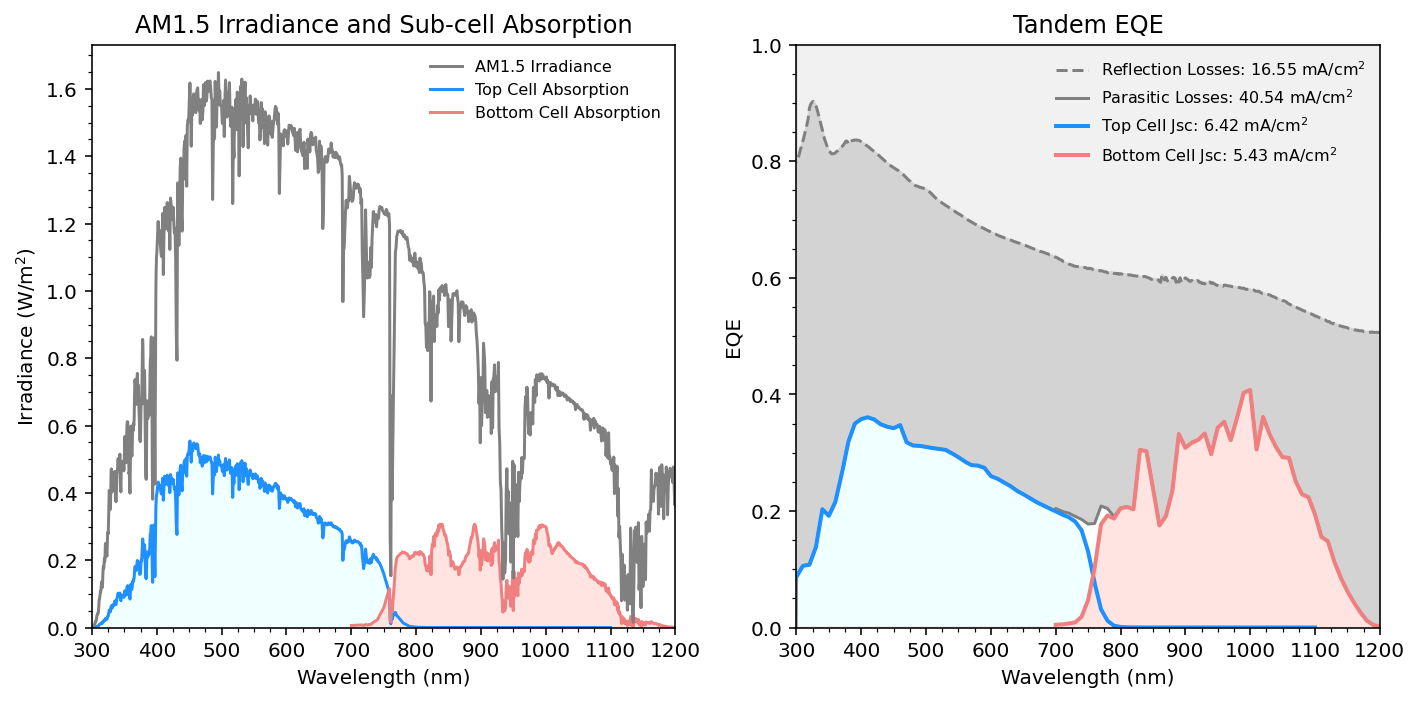

In [41]:
plot_tandem_solar_cells(EQE_top_fp, EQE_bot_fp, R_fp, Spectrum_fp)